In [54]:
import pandas as pd
import numpy as np
import random
import inspect
import warnings
import seaborn as sns
from pygam import LinearGAM, s, f, l
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as stats2
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.genmod.generalized_linear_model import GLMResults
from statsmodels.formula.api import ols,glm
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error,r2_score, confusion_matrix, precision_recall_fscore_support,roc_curve, accuracy_score, roc_auc_score
from dmba import stepwise_selection,AIC_score,classificationSummary

warnings.filterwarnings('ignore')


In [2]:
df_prueba = pd.DataFrame({
"ES_NO_ES":[np.random.choice(['s','n']) for _ in range(1000)],
"sexo":[np.random.choice(['h','m']) for _ in range(1000)],
"Datos_C":[np.random.choice([0,1]) for _ in range(1000)],
"Datos_D": list(np.random.standard_normal(1000)),
"Datos_E": list(np.random.standard_normal(1000)),
"Datos_Poisson_1": list( stats.poisson.rvs(mu=4, size=1000)),
"Datos_Poisson_3": list( np.random.poisson(lam=10, size=1000)),
"Datos_Geom": list( stats.geom.rvs(0.75, size=1000)),
"Datos_F": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_G": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_cate_A": ['Grupo '+str(np.random.randint(0,6)) for _ in range(1000)],
"Datos_cate_B": ['Grupo '+str(np.random.randint(0,4)) for _ in range(1000)],
"Datos_cate_C": [np.random.randint(0,60) for _ in range(1000)],

})

# for i in range(1,6):
#     df_prueba['Datos_E'][random.randint(0,23)]=None


# for i in range(1,10):
#     df_prueba['Datos_F'][random.randint(0,23)]=None

# for i in range(0,11):
#     df_prueba['Datos_G'][i]=None

    
lista_de_items= ['Item '+str(np.random.randint(0,6)) for _ in range(30000)]
num_fact= 30000

def crear_lista (lista):
    listafin=[]
    for i in range (0,num_fact):
        lista_aux=[]
        for j in range(1, random.randint(1, 10)):
            lista_aux.append(random.choice(lista))
        
        listafin.append(lista_aux)
    
    return listafin

# facturas=crear_lista(lista_de_items)


# df_prueb2 = pd.DataFrame({
# "Items": lista_de_items,
# "facturas": facturas,
# })

# pd.merge(df_prueba, df_prueb2,left_index=True, right_index=True)



In [3]:

class DF_exploracion(pd.DataFrame):

    def __init__(self, *args, **kw):
        super(DF_exploracion, self).__init__(*args, **kw)
        self.cuanti=pd.DataFrame
        self.cuanti_antes_de_outliers_y_inputs=pd.DataFrame
        self.cuali=pd.DataFrame
        self.dico=pd.DataFrame
        self.cate=pd.DataFrame
        self.eliminado=pd.DataFrame
        self.dummy=pd.DataFrame
        self.df=pd.DataFrame
        self.df_inputado=pd.DataFrame
        self.df_limpio=pd.DataFrame
        self.predicotres=pd.DataFrame
        self.outcome=pd.DataFrame
        # self.outcome_col=self.outcome.columns
        self.normal_cuatis=[]
        self.normal_grupos_dico=[]
        self.normal_grupos_cate=[]
        self.discreta=[]
        self.stingg=[]
        self.outliers_hecho=True
        self.porcentaje_nulos_permitido=0.3

    def variables(self):

        dico=[]
        cuantis=[]
        categori=[]
        eliminar=[]
        

        for i in self.columns: 

            try:
                datos=self[i].dropna().to_numpy()
                discreta=True
                for j in datos:
                    if (j%1 !=0):
                        discreta=False
                        break
                    else:
                        continue
                if (discreta):
                    self.discreta.append(i)
            except:
                self.stingg.append(i)

            nulos= (self[i].isnull().sum())/len(self[i])
            
            if ((len(self[i].dropna().unique())==2) and (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: DICOTOMICA"
                dico.append(i)

            elif ((len(self[i].dropna().unique())>10) and  (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CUANTITATIVA"
                cuantis.append(i)

            elif ( (len(self[i].dropna().unique())<2) or (nulos>self.porcentaje_nulos_permitido)):
                tipo_de_var=f"SOLO {len(self[i].dropna().unique())} TIPOS, NO VALE LA COLUMNA"
                eliminar.append(i)
            else:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CATEGORICA/CUANTI"
                categori.append(i)

            print (f"|  {i} \n|   - Tipo de dato: {self[i].dtype} \n|   - Valores repetidos: {tipo_de_var} \n|   - Nulos: {nulos} \n| ")

        print (f"|----------------------------------------------------------------------------------------------------\n|  TODAS: {self.columns} \n|  DICOTOMICAS: {dico} \n|  CATEGORICAS: {categori} \n|  CUANTITATIVAS: {cuantis} \n|  ELIMINAR: {eliminar}")
        print("|----------------------------------------------------------------------------------------------------")

        


        self.DF_cuantis(cuantis)
        self.DF_cualis(categori+dico)
        self.DF_dicotomica(dico)
        self.DF_categorica(categori)
        self.DF_elimiminado(eliminar)
        self.df=self
        
    def todas_col(self):
        return self.df
    
    def DF_cuantis(self,lista):
        self.cuanti=self[lista]

    def DF_elimiminado(self,lista):
        self.eliminado=self[lista]
        
    def DF_cualis(self,lista):
        self.cuali=self[lista]
        
    def DF_dicotomica(self, lista):
        self.dico=self[lista]
        
    def DF_categorica(self, lista):
        self.cate=self[lista]   



    def limpiar_aux(self):
        
        try:
            df_nuevo=pd.DataFrame
            aux1=list(self.dico.columns)
            aux=[]
            df_nuevo=pd.get_dummies(self.df, columns=aux1)
            
            for columna in df_nuevo.columns:
                for variables in list(self.dico.columns):
                    if variables in columna:
                        aux.append(columna)
                    
            self.dummy=df_nuevo[aux]
            self[aux]=df_nuevo[aux]

            # self.df=self.drop(columns=var, axis='columns')
            # self.df= self[self.columns.difference(self.dico.columns)]
            
            print("********************** self.dummy ************\n")
            print(self.dummy)
            print("\n********************** self.df o todas_las_col() ************\n")
            print(self.df)

        except:
            print("---------------------- ERROR -----------------")



    def limpiar_dummys(self):

        b=False
        lista=list(self.dico.columns)
        for ind, i in enumerate(lista):
                if (ind+1<len(lista)):
                    if( (i in lista [ind+1]) ):
                        b=True
                        break
        if b:
            nombres_nuevos=[]
            if len(lista)>2:
                for ind, i in enumerate(lista):
                    if (ind+1<len(lista)):
                        if( (i in lista [ind+1]) ):
                            nombres_nuevos.append(i.upper())
                        else:
                            nombres_nuevos.append(i)
                    else:
                        nombres_nuevos.append(i)
                        
            aux_df=self.df

            for i,j in zip(lista,nombres_nuevos):
                aux_df.rename(columns={i:j},inplace=True)
                
            self.df=aux_df
            self.dico.columns=nombres_nuevos
            
            self.limpiar_aux()
        else: 
            self.limpiar_aux()



    def estadistica_descriptiva_cuantis(self):

        print("----------------------------------------------------------------------------------------------------\nDESCRIPCIÓN")
        print (self.cuanti.describe())
        print("\n")
        print("----------------------------------------------------------------------------------------------------\nCUARTILES")
        print (self.cuanti.quantile([0.05,0.25,0.5,0.75,0.95]))
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")


        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        # df_auxiliar = self.groupby('sexo').apply(lambda x: pd.Series(shapiro(x), index=['W','P'])).reset_index()
        # print(df_auxiliar)
                
        for a in list(aux1.values):
            
            for b in list(aux.values):
                
                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                agrupado=self.groupby(a)[b]
                titulo=f"Agrupado por {a} y por {b}"
                print(titulo)
                print(agrupado.describe().reset_index())
                # df.groupby(['cat1', 'cat2'])['purchases','sales'].apply(stats.shapiro)
                print("////////////////////////// TEST DE SHAPIRO ////////////////////////////")
                aux_shapiro=(agrupado.apply(stats.shapiro))
                print(aux_shapiro)
        
                
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")


    def estadistica_descriptiva_cualis(self):

        print("\n--------------------- Variables dico ---------------------")
        print("\n")
        for i in self.dico.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")

        print("\n-------------------- Variables categoricas --------------------")
        print("\n")
        for i in self.cate.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")
        print("\n\n")

        # crosstab variables cualis con cate
        aux=list(self.cate.columns)

        a=0
        for i in aux:
            a=a+1
            if a<len(aux)/2:
                b=0
                for j in aux[:-1]:
                    b=b+1
                    if b > a:
                        print(f"*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} *********************\n ")
                        tab = pd.crosstab (index=self[i], columns=self[j])
                        x=(tab/tab.sum())
                        print(tab)
                        print("\n")
                        print(f"/////////////////// EN PROPORCION //////////////////\n")
                        print(x)
                        print("\n\n")


    def anova(self):

        aux_cate=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for i in aux_cate:
            for j in aux_cuati:
                try:
                    print(f"\n----------- ANOVA Categoria {i} y variable continua {j} ----------\n")
                    model = ols(f"{j} ~ {i}", data=self).fit()
                    a=sm.stats.anova_lm(model, typ=2)
                    print(a)
                except:
                    print(f"\n - - - - - Fallo en variable {i} y {j} - - - - - - \n")
                    continue




    def Chi(self):

        aux_dico=list(self.dico.columns)

        if len(aux_dico)>1:
            for ind, i in enumerate(aux_dico):
                for j in range(ind+1,len(aux_dico)):
                    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(self[i],self[aux_dico[j]]), correction=False)
                    print(f"\n-------------- Chi2 entre {i} y {aux_dico[j]} ----------------")
                    print(f"p: {p} \n") 
        else:
            print("******************** No suficientes argumentos ********************")


    def t_test_aux(self, columns):
        results = []
        for i, col1 in enumerate(columns[:-1]):
            for col2 in columns[i+1:]:
                t, p = stats.ttest_ind(self[col1].dropna(), self[col2].dropna(), equal_var=False)
                # results.append((col1, col2, t, p))
                if p < 0.05:
                    print( f"+++++ Variable{col1}, variable 2 {col2} con p de: \033[1m{p}\033[0m  Se RECHAZA H0 ++++") 
                else:
                    print( f"+++++ Variable{col1}, variable 2 {col2}  con p de: {p} SE ACEPTA H0 ++++") 
    
    def wilcoxon_test_aux(self,col1, col2):
        if (col1== col2).all():
            print ("\nLas coluimnas son iguales\n")
        res = stats.wilcoxon(col1, col2)
        if res.pvalue < 0.05:
            print(f"Reject null hypothesis. Significant difference  (p-value={res.pvalue:.4f})")
        else:
            print (f"Fail to reject null hypothesis. No significant difference (p-value={res.pvalue:.4f})")

    def wilconxon(self, lista):
        # lista=[grupo, var]
        a,b=self.agrupar(lista)
        print(f"\n- Variable: {lista[1]}, Grupo: {lista[0]}")
        self.wilcoxon_test_aux(a, b)

    def agrupar (self, lista):
        groupby_col=lista[0]
        col=lista[1]
        valor=self[groupby_col].unique()
        group= self.where(self[groupby_col]== valor[0])[col]
        group2= self.where(self[groupby_col]== valor[1])[col] 
        return group,group2

    # def t_test_groupby_one_col(self, col, groupby_col):
        
    #     group= self.where(self[groupby_col]== self[groupby_col][0]).dropna()[col]
    #     group2= self.where(self[groupby_col]== self[groupby_col][1]).dropna()[col]
    #     t, p = stats.ttest_ind(group, group2, equal_var=False)
    #     print( col, groupby_col,p) 

    def t_test_all(self):
        aux=list(self.cuanti.columns)
        aux2=list(self.dico.columns)
        self.t_test_aux(self.normal_cuatis) #aqui ya hace todas las cuantis entre ellas faltan los grupos
        for i in self.normal_grupos_dico:
            a,b=self.agrupar(i)
            t, p = stats.ttest_ind(a.dropna(), b.dropna(), equal_var=False)
            if p < 0.05:
                print( f"+++++ Variable{i[1]}, Agrupado por {i[0]} con p de: \033[1m{p}\033[0m  Se RECHAZA H0 ++++") 
            else:
                print( f"+++++ Variable{i[1]}, Agrupado por {i[0]} con p de: {p} SE ACEPTA H0 ++++") 
    # df_prueba.groupby('sexo').apply(lambda df: stats.ttest_ind(df['Datos_D'].dropna(), df['Datos_E'].dropna())[1])


    def plot_confidence_interval(self, col, confidence_level= 0.95):
        data = self[col].to_numpy()
        n = len(data)
        mean =self[col].mean(axis=0)
        # std_error = stats.sem( self[col].dropna())
        std_error = self[col].dropna().std()
        lower_bound = stats.t.ppf(0.025, n - 1, loc = mean, scale = std_error)  # =>  99.23452406698323
        upper_bound = stats.t.ppf(0.975, n - 1, loc = mean, scale = std_error)
        # h = std_error * stats.t.ppf((1 + confidence_level) / 2, n - 1)
        
        # lower_bound = mean - h
        # upper_bound = mean + h
        # plt.hist(data, bins=30, edgecolor='black', alpha=0.5)
        # plt.axvspan(lower_bound, upper_bound, color='gray', alpha=0.2, label=f'{confidence_level * 100}% Confidence Interval')
        # plt.axvline(x=mean, color='red', label='Sample Mean')
        # plt.legend()

        fig, ax = plt.subplots()
        ax.hist(data, bins=30, edgecolor='black', alpha=0.5)
        ax.axvline(x=mean, color='red', label='Sample Mean')
        ax.axvspan(lower_bound, upper_bound, color='grey', alpha=0.5, label=f'{confidence_level * 100}% Confidence Interval')
        ax.annotate(
            f'lower_bound:\n {lower_bound:.2f}',
            xy=(lower_bound, 0), xytext=(lower_bound-0.5, 50)
        )
        ax.annotate(
            f'upper_bound:\n  {upper_bound:.2f}',
            xy=(upper_bound, 0), xytext=(upper_bound-0.5, 50)
        )
        ax.legend()
        
        plt.show()


    def plot_normailidad(self):
        aux=self.cuanti.columns
        for i in aux:
            stats.probplot(self[i], dist="norm", plot=plt)
            plt.title("Probability Plot - " )
            plt.show()
    


    def plot_bigotes(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

        print("-------------- Graficas de bigotes cualitativas-------------------")
        # fig = plt.figure(figsize=(12, 8))
        
        (self.cuanti).plot(kind='box', title='Variables cuantitativas',figsize=(12, 8))
        plt.show()
        

        print("-------------- Graficas de bigotes por dicotomicas-------------------")   
        
        for a in aux1:

            # fig = plt.figure(figsize=(12, 8))
            self.boxplot(column=list(aux.values), by=a,figsize=(12, 8))
            plt.tight_layout() 
            plt.show()
        
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- Graficas de bigotes por categoricas-------------------") 

        for a in aux2:
            # fig = plt.figure(figsize=(12, 8))
            ax= self.boxplot(column=list(aux.values), by=a, figsize=(12, 8))
            # ax = sns.swarmplot(column=list(aux.values), by=a,data=self, color='#7d0013')
            plt.tight_layout() 
            plt.show()
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")

        
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")



    def plot_corr(self):

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------\n") 

        fig = plt.figure(figsize=(12, 8))
        matrix = self.cuanti.corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)  
        plt.show()

        print("----------------------------------------------------------------------------------------------------\n")

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def plot_barras(self):
        aux=self.cuanti.columns

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")

        print("-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------\n") 
        # fig = plt.figure(figsize=(15, 20))
        self.cuanti.plot.bar(figsize=(18, 8))
        plt.show()

        print("-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------\n") 
        for i in list(aux.values):
            fig = plt.figure(figsize=(12, 8))
            print(f"\n.............. GRAFICA DE BARRAS  DE {i} ............\n") 
            ax=self[i].plot.hist(density=True)
            self[i].plot.density(ax=ax)
            plt.show()

        print("----------------------------------------------------------------------------------------------------\n")    
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def todos_plots(self):

        self.plot_bigotes()
        self.plot_corr()
        self.plot_barras()
        self.violines()
        
        

    def violines(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("--------------  GRAFICA DE VIOLINES  -------------------\n") 
        sns.set(style="whitegrid")
        for i in aux2:
            for j in aux:
                ax= sns.violinplot(x=self[i], y=self[j], palette="Set2", split=True, inner="quartile",scale="count")
                plt.show()

        print("\n\n/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////\n") 
        
        for i in aux2:
            for j in aux:
                for k in aux1:
                    ax= sns.violinplot(x=self[i], y=self[j], hue=self[k],palette="Set2", split=True, inner="quartile",scale="count")
                    plt.show()


    def cross_var_cualis_con_ciantis(self):

        aux=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for k in aux_cuati:
            a=0
            for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            print(f"\n\n*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} con valores de {k} MEDIA *********************\n ")
                            tab = pd.crosstab (index=self[i], columns=self[j],values=self[k],aggfunc=np.mean)
                            print(tab)
                            print("\n\n")

    def nulos(self):
        aux_df=list(self.cuanti.columns)
        self.inputado=self.df
        for i in aux_df:
            nulos=self[i].isna().sum()
            total=len(self[i])
            porcentaje=nulos/total
            if ((nulos>0)):
                percen=self[i].quantile([0.2,0.8]).to_list()
                self[i]=self[i].apply(lambda x: ( random.randint ( round(percen[0]) , round(percen[1]) )) if pd.isna(x) else x )
                print(f"\n- Se han inputado {nulos} nulos a la variable {i} (tenía porcentaje de nulos de: {porcentaje}) \n")
            elif (porcentaje>self.porcentaje_nulos_permitido):
                print(f"\n - No se ha podido inputar a la variable {i} porque el porcentaje de nulos era de {porcentaje}\n")
                

    def normalidad(self):
        
        DataF=self.df
        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
                
        for b in list(aux.values):
            aux_shapiro=(stats.shapiro(DataF[b]))
            if(aux_shapiro.pvalue<0.05):
                print("////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////")
                print("++++++++++++++++++++++++++++  "+ b +"  ++++++++++++++++++++++++++\n")
                titulo=f"Variable cuantitativa {b} y test Shapiro < 0.05"
                print(titulo)
                print(aux_shapiro)
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")
                self.normal_cuatis.append(b)

        for a in list(aux1.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby(a)[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(aux_shapiro)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_dico.append([a,b])
                    except:
                        continue 

        for a in list(aux2.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby([a])[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO CATEGORICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(h)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_cate.append([a,b])
                    except:
                        continue 

        self.normal_grupos_dico=[i for n, i in enumerate(self.normal_grupos_dico) if i not in self.normal_grupos_dico[:n]]
        self.normal_grupos_cate=[i for n, i in enumerate(self.normal_grupos_cate) if i not in self.normal_grupos_cate[:n]]
        
    def detec_outlaiers(self):
        aux=list(self.cuanti.columns)
        aux_DF=self.cuanti
        for i in aux:
            z = np.abs(stats.zscore(aux_DF[i]))
            print(z)
    
    def seleccionar_distribuciones(self,familia='realall', verbose=False):
        '''
        Parameters
        ----------
        familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
            realall: distribuciones de la familia `realline` + `realplus`
            realline: distribuciones continuas en el dominio (-inf, +inf)
            realplus: distribuciones continuas en el dominio [0, +inf)
            real0to1: distribuciones continuas en el dominio [0,1]
            discreta: distribuciones discretas
            
        verbose : bool
            Si se muestra información de las distribuciones seleccionadas
            (the default `False`)
        '''
    
        distribuciones = [getattr(stats,d) for d in dir(stats) \
                        if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
        
        exclusiones = ['levy_stable', 'vonmises']
        distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
                
        dominios = {
            'realall' : [-np.inf, np.inf],
            'realline': [np.inf,np.inf],
            'realplus': [0, np.inf],
            'real0to1': [0, 1], 
            'discreta': [None, None],
        }

        distribucion = []
        tipo = []
        dominio_inf = []
        dominio_sup = []

        for dist in distribuciones:
            distribucion.append(dist.name)
            tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
            dominio_inf.append(dist.a)
            dominio_sup.append(dist.b)
        
        info_distribuciones = pd.DataFrame({
                                'distribucion': distribucion,
                                'tipo': tipo,
                                'dominio_inf': dominio_inf,
                                'dominio_sup': dominio_sup
                            })

        info_distribuciones = info_distribuciones \
                            .sort_values(by=['dominio_inf', 'dominio_sup'])\
                            .reset_index(drop=True)
        
        if familia in ['realall', 'realline', 'realplus', 'real0to1']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
            condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                        (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
            info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
            
        if familia in ['discreta']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
            
        seleccion = [dist for dist in distribuciones \
                    if dist.name in info_distribuciones['distribucion'].values]
        
        
        if verbose:
            print("---------------------------------------------------")
            print("       Distribuciones seleccionadas                ")
            print("---------------------------------------------------")
            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(info_distribuciones)
        
        return seleccion


    def plot_multiple_distribuciones(self, nombre_distribuciones):

        aux=list(self.cuanti.columns)
        fig, ax = plt.subplots(figsize=(15,15))

        for i in aux:
            x=self[i]
            if ax is None:
                fig, ax = plt.subplots(figsize=(7,4))
                
            ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
            ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
            ax.set_title('Ajuste distribuciones')
            ax.set_xlabel('x')
            ax.set_ylabel('Densidad de probabilidad')
            
            for nombre in nombre_distribuciones:
                
                distribucion = getattr(stats, nombre)

                parametros = distribucion.fit(data=x)

                nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                    if not p=='x'] + ["loc","scale"]
                parametros_dict = dict(zip(nombre_parametros, parametros))

                log_likelihood = distribucion.logpdf(x, *parametros).sum()

                aic = -2 * log_likelihood + 2 * len(parametros)
                bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                x_hat = np.linspace(min(x), max(x), num=100)
                y_hat = distribucion.pdf(x_hat, *parametros)
                ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
            ax.legend()
            plt.show()
        


    def fit_discrete(self,datos):

        # self.discreta

        mean = datos.mean()
        var = datos.var()
        likelihoods = {}  
        log_likelihoods = {}

        p = 1 - mean / var  
        r = (1-p) * mean / p



        log_likelihoods['nbinom'] = datos.map(lambda val: stats.nbinom.logpmf(val, r, p)).sum()

        lambda_ = mean

        log_likelihoods['poisson'] = datos.map(lambda val: stats.poisson.logpmf(val, lambda_)).sum()


        best_fit = max(log_likelihoods, key=lambda x: log_likelihoods[x])
        print("**** Best fit between poisson and nbinorm :", best_fit)
        

    
        plt.hist(datos, bins=int(np.max(datos)), density=True, alpha=0.5)

        mean = datos.mean()
        var = datos.var()


        def loss_function_poisson(params, datos_in):

            mu = params[0]

            loss = 0

            for i in range(len(datos_in)):

                loglikelihood = stats.poisson.logpmf(datos_in[i], mu)

                loss_to_add = -loglikelihood

                loss += loss_to_add

            return(loss)




        params0 = np.array([20])
        minimum = stats2.optimize.fmin(loss_function_poisson, params0, args=(datos,))

        mu_fit = minimum[0]

        print("***********  The best mu_fit is:  ",  mu_fit)
        print("\n")

        x = list(range(int(np.min(datos)), int(np.max(datos))+1))
        plt.scatter(x, stats.poisson.pmf(x, mu_fit),color="red")
        plt.show()   

        print("\n\n Otras variables discretas:  ",  self.discreta)


    def comparar_distribuciones_caunti_cont(self, ordenar='aic', verbose=False):

            '''
            resultados: data.frame
                distribucion: nombre de la distribución.
                log_likelihood: logaritmo del likelihood del ajuste.
                aic: métrica AIC.
                bic: métrica BIC.
                n_parametros: número de parámetros de la distribución de la distribución.
                parametros: parámetros del tras el ajuste
                
            Raises
            ------
            Exception
                Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
                o 'discreta'.
                
            Notes
            -----
            '''
            aux=list(self.cuanti.columns)
            
            for i in aux:
                print(f"\n ******************** Variable: {i} ******************** \n")
                x=self[i]
                distribuciones = self.seleccionar_distribuciones(familia='realall',verbose=verbose)
                distribucion_ = []
                log_likelihood_= []
                aic_ = []
                bic_ = []
                n_parametros_ = []
                parametros_ = []
                
                for j, distribucion in enumerate(distribuciones):
                    
                    # print(f"{j+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
                    
                    try:
                        parametros = distribucion.fit(data=x)
                        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                            if not p=='x'] + ["loc","scale"]
                        parametros_dict = dict(zip(nombre_parametros, parametros))
                        log_likelihood = distribucion.logpdf(x, *parametros).sum()
                        aic = -2 * log_likelihood + 2 * len(parametros)
                        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
                        
                        distribucion_.append(distribucion.name)
                        log_likelihood_.append(log_likelihood)
                        aic_.append(aic)
                        bic_.append(bic)
                        n_parametros_.append(len(parametros))
                        parametros_.append(parametros_dict)
                        
                        resultados = pd.DataFrame({
                                        'distribucion': distribucion_,
                                        'log_likelihood': log_likelihood_,
                                        'aic': aic_,
                                        'bic': bic_,
                                        'n_parametros': n_parametros_,
                                        'parametros': parametros_,
                            
                                    })
                        
                        resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

                        
                        
                    except Exception as e:
                        print(f"Error al tratar de ajustar la distribución {distribucion.name}")
                        print(e)
                        print("")

                nombre_distribuciones=resultados['distribucion'][:5]
                fig, ax = plt.subplots(figsize=(7,4))
                
                
                ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
                ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
                ax.set_title('Ajuste distribuciones')
                ax.set_xlabel('x')
                ax.set_ylabel('Densidad de probabilidad')
                
                for nombre in nombre_distribuciones:
                    
                    distribucion = getattr(stats, nombre)

                    parametros = distribucion.fit(data=x)

                    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                        if not p=='x'] + ["loc","scale"]
                    parametros_dict = dict(zip(nombre_parametros, parametros))

                    log_likelihood = distribucion.logpdf(x, *parametros).sum()

                    aic = -2 * log_likelihood + 2 * len(parametros)
                    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                    x_hat = np.linspace(min(x), max(x), num=100)
                    y_hat = distribucion.pdf(x_hat, *parametros)
                    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
                ax.legend()
                plt.show()

                print("\n")
                print(resultados.head(5))    
                print("\n------------------------------------------------------------------\n")

    def remove_outliers(self, k=1.5):
        aux=list(self.cuanti.columns)
        for column in aux:
            print(f"\n\n                    <<<<<<<<<<<<<<<<<<<<<<<< {column} >>>>>>>>>>>>>>>>>>>>>>>>\n\n")
            self.plot_outliers2(column, k=1.5)
            q1, q3 = self[column].quantile([0.25, 0.75])
            iqr = q3 - q1
            lower_bound = q1 - (k * iqr)
            upper_bound = q3 + (k * iqr)
            self.loc[(self[column] < lower_bound) | (self[column] > upper_bound), column] = None    
        self.nulos()
        self.outliers_hecho=False


    def plot_outliers(self, column, k=1.5):
        
        q1, q3 = self[column].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - (k * iqr)
        upper_bound = q3 + (k * iqr)
        
        fig, ax = plt.subplots()
        ax.scatter(self.index, self[column], color='blue', label='inlier')
        ax.scatter(self[(self[column] < lower_bound) | (self[column] > upper_bound)].index,
                self[(self[column] < lower_bound) | (self[column] > upper_bound)][column],
                color='red', label='outlier')
        ax.axhline(lower_bound, color='gray', linestyle='--')
        ax.axhline(upper_bound, color='gray', linestyle='--')
        plt.legend()
        plt.show() 

    
    def plot_outliers2(df, column, k=1.5):
        q1, q3 = df[column].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - (k * iqr)
        upper_bound = q3 + (k * iqr)
        
        fig, ax = plt.subplots()
        ax.plot(df.index, df[column], color='blue')
        ax.scatter(df[df[column].isnull()].index,
                df[df[column].isnull()][column],
                color='red', marker='x')
        ax.axhline(lower_bound, color='red', linestyle='--')
        ax.axhline(upper_bound, color='red', linestyle='--')
        plt.show()
        
    def plot_xy_data(df, x_column, y_column):
        fig, ax = plt.subplots()
        ax.scatter(df[x_column], df[y_column])
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.show()


    def reg_lineal(self, predictores, OUTCOME):
        aux1=set(predictores)
        aux2=set(list(self.cuali.columns))
        

        if (aux1.intersection(aux2)): 
            print("Tienes alguna variable cualitativa en los predictores")
        elif(OUTCOME in list(self.cuali.columns)):
            print("OUTCOME es cualitativa") 
        #No funciona con NA ni con distinta longitud dentro de los DF
        if (self.outliers_hecho):
            try:
                self.remove_outliers()
                self.predicotres=self[predictores]
                self.outcome=self[OUTCOME]
                ej_lm=LinearRegression()
                ej_lm.fit(self.predicotres,self.outcome)

                for name, coef in zip(predictores,ej_lm.coef_):
                    print(f"{name}: {coef}")

                fitted= ej_lm.predict(self.predicotres)
                RMSE= np.sqrt(mean_squared_error(self.outcome,fitted))
                r2= r2_score(self.outcome,fitted) 

                # RMSE es como el accuracy del modelo (es practicamente igual al RSE)
                print(f"- RMSE: {RMSE:.0f}")

                # coeficiente de determinación:  0-1 proporción de varianza en los datos
                # que estan contabilizados en el modelo
                print(f"- R2: {r2:.4f}")
                model=sm.OLS(self.outcome,self.predicotres.assign(const=1) )
                resul=model.fit()
                print("\n - RESUMEN \n")
                print( resul.summary())
                return ej_lm
            except:
                print("Puede que haya columans con distinta longitud")

        elif (self[predictores].isna().any().any()):
            print("HAY VALORES NULOS EN LAS COLUMNAS Y YA HAS HECHO LA FUNCIÓN DE OUTLIERS")

        else :
            try:
                self.predicotres=self[predictores]
                self.outcome=self[OUTCOME]
                ej_lm=LinearRegression()
                ej_lm.fit(self.predicotres,self.outcome)

                for name, coef in zip(predictores,ej_lm.coef_):
                    print(f"{name}: {coef}")

                fitted= ej_lm.predict(self.predicotres)
                RMSE= np.sqrt(mean_squared_error(self.outcome,fitted))
                r2= r2_score(self.outcome,fitted) 

                # RMSE es como el accuracy del modelo (es practicamente igual al RSE)
                print(f"- RMSE: {RMSE:.0f}")

                # coeficiente de determinación:  0-1 proporción de varianza en los datos
                # que estan contabilizados en el modelo
                print(f"- R2: {r2:.4f}")
                model=sm.OLS(self.outcome,self.predicotres.assign(const=1) )
                resul=model.fit()
                print("\n ------------------------- RESUMEN --------------------------- \n")
                print( resul.summary())
                return ej_lm
            except:
                print("Puede que haya columans con distinta longitud")


    def forward_selected(self):
        """Linear model designed by forward selection.

        Parameters:
        -----------
        data : pandas DataFrame with all possible predictors and response

        response: string, name of response column in data

        Returns:
        --------
        model: an "optimal" fitted statsmodels linear model
            with an intercept
            selected by forward selection
            evaluated by adjusted R-squared
        """
        data=pd.merge(self.predicotres, self.outcome,left_index=True, right_index=True)
        response=self.outcome.columns[0]

        remaining = set(data.columns)
        remaining.remove(response)
        selected = []
        current_score, best_new_score = 0.0, 0.0
        while remaining and current_score == best_new_score:
            scores_with_candidates = []
            for candidate in remaining:
                formula = "{} ~ {} + 1".format(response,
                                            ' + '.join(selected + [candidate]))
                score = ols(formula, data).fit().rsquared_adj
                scores_with_candidates.append((score, candidate))
            scores_with_candidates.sort()
            best_new_score, best_candidate = scores_with_candidates.pop()
            if current_score < best_new_score:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
        formula = "{} ~ {} + 1".format(response,
                                    ' + '.join(selected))
        model = ols(formula, data).fit()

        print (f"Formula: {model.model.formula}")
        print (f"Ajuste por R2: {model.rsquared_adj}")

        return model




    def weighted_regression(self, weights):
        X = self.predicotres.values
        y = self.outcome.values
        w = weights.values

        model = LinearRegression()
        model.fit(X, y, sample_weight=w)

        return model
    
    def codificar_catego(self,modelo,cate_var:str):
        self['residuos']=(self.outcome-modelo.predict(self.predicotres))
        self['residuos']
        self[cate_var]= self[cate_var]
        grupos1_aux= pd.merge(self[cate_var], self['residuos'],left_index=True, right_index=True)
        grupos1_agrupado=grupos1_aux.groupby([cate_var])

        summary_function = lambda x: {
            cate_var: x.iloc[0,0],
            'count': len(x),
            'residuo_medio': x.residuos.median()
        }
        
        group_summaries = grupos1_agrupado.apply(summary_function)
        final_df = pd.DataFrame([    *group_summaries])
        grupos1 = final_df.sort_values('residuo_medio')
        grupos1['cum_count']=np.cumsum(grupos1['count'])
        grupos1['Col_a_codificar_grupos']=pd.qcut(grupos1['cum_count'],5,labels=False,retbins=False)
        to_join= grupos1[[cate_var,'Col_a_codificar_grupos']].set_index(cate_var)

        self=self.join(to_join, on=cate_var)
        return (self[[cate_var,'Col_a_codificar_grupos']])
    
    def regre_con_interaccion_de_var(self,outcome,predictores,lista_predictores_condicionados):
        frase=outcome+" ~"
        frase_aux1=""
        frase_aux2=""
        aux=0
        for i, j in lista_predictores_condicionados:
            if aux==0:
                frase_aux1=i+"*"+j
            else:
                frase_aux1=frase_aux1+"+"+i+"*"+j
            aux=aux+1
        for i in predictores:
            frase_aux2=frase_aux2+"+"+i
        frase=frase+frase_aux1+frase_aux2
        print(f" Formula final: {frase} \n\n")
        model=smf.ols(formula= frase,data=self )
        results=model.fit()
        return results.summary()
    

    def regre_outliers(self, cate=None, grupo=None):

        if cate==None:
            ej_outliers=sm.OLS(self.outcome, self.predicotres.assign(conts=1))
            resul_1=ej_outliers.fit()

            influence=OLSInfluence(resul_1)
            sresiduals= influence.resid_studentized_internal

            outliers=self.loc[sresiduals.idxmin(), :]
            print("resultado", outliers[list(self.outcome.columns)])
            print(outliers[list(self.predicotres.columns)])


            print("puntos con alta influencia y distancia de Cooks mayor de 0.08")
            fig, ax=plt.subplots(figsize=(5,5))
            ax.axhline(-2.5, linestyle='--', color='C1')
            ax.axhline(2.5, linestyle='--', color='C1')
            ax.scatter(influence.hat_matrix_diag, 
                    influence.resid_studentized_internal,
                    s=1000*np.sqrt(influence.cooks_distance[0]), 
                    alpha=0.5)
            ax.set_xlabel('hat values')
            ax.set_ylabel('studentized residuals')
            plt.show()


            print("predictores vs residuos para ver heteroskedascity")
            fig, ax=plt.subplots(figsize=(5,5))
            df = pd.DataFrame({'fitted': resul_1.fittedvalues, 
                            'residuals': np.abs(resul_1.resid)})
            sns.regplot(x='fitted', y='residuals', data=df, scatter_kws={'alpha':0.25}, line_kws={'color': 'C1'}, lowess=True, ax=ax)
            ax.set_xlabel('predictos')
            ax.set_ylabel('abs(residuos)')
            plt.show()

        else:
            datos_agru=self.loc[df_prueba[cate]==grupo,]
            ej_outliers=sm.OLS(datos_agru[list(self.outcome.columns)], datos_agru[list(self.predicotres.columns)].assign(conts=1))
            resul_1=ej_outliers.fit()

            influence=OLSInfluence(resul_1)
            sresiduals= influence.resid_studentized_internal

            outliers=datos_agru.loc[sresiduals.idxmin(), :]
            print("resultado", outliers[list(self.outcome.columns)])
            print(outliers[list(self.predicotres.columns)])

            print("puntos con alta influencia y distancia de Cooks mayor de 0.08")
            fig, ax=plt.subplots(figsize=(5,5))
            ax.axhline(-2.5, linestyle='--', color='C1')
            ax.axhline(2.5, linestyle='--', color='C1')
            ax.scatter(influence.hat_matrix_diag, 
                    influence.resid_studentized_internal,
                    s=1000*np.sqrt(influence.cooks_distance[0]), 
                    alpha=0.5)
            ax.set_xlabel('hat values')
            ax.set_ylabel('studentized residuals')
            plt.show()

            print("predictores vs residuos para ver heteroskedascity")
            fig, ax=plt.subplots(figsize=(5,5))
            df = pd.DataFrame({'fitted': resul_1.fittedvalues, 
                            'residuals': np.abs(resul_1.resid)})
            sns.regplot(x='fitted', y='residuals', data=df, scatter_kws={'alpha':0.25}, line_kws={'color': 'C1'}, lowess=True, ax=ax)
            ax.set_xlabel('predictos')
            ax.set_ylabel('abs(residuos)')
            plt.show()

    def infl_residual_modelo(self, var_influ, cate=None, grupo=None):
        if cate==None:
            ej_outliers=sm.OLS(self.outcome, self.predicotres.assign(conts=1))
            resul_1=ej_outliers.fit()
            sm.graphics.plot_ccpr(resul_1,var_influ)
            fig = plt.figure(figsize=(12, 12))
            fig = sm.graphics.plot_ccpr_grid(resul_1, fig=fig)
        
        else:
            datos_agru=self.loc[df_prueba[cate]==grupo,]
            ej_outliers=sm.OLS(datos_agru[list(self.outcome.columns)], datos_agru[list(self.predicotres.columns)].assign(conts=1))
            resul_1=ej_outliers.fit()
            sm.graphics.plot_ccpr(resul_1,var_influ)
            fig = plt.figure(figsize=(12, 12))
            fig = sm.graphics.plot_ccpr_grid(resul_1, fig=fig)

    def regre_poly(self,variables_exp,expo,cate=None, grupo=None,verbose=False):

        if cate==None:

            out=list(self.outcome.columns)
            predic=list(self.predicotres.columns)

            frase=out[0]+" ~ "
            variables_no_exp = [element for element in predic if element not in variables_exp]
            frase_expo=""
            frase_no_expo=""

            for i,j in zip(variables_exp,expo):
                frase_expo=frase_expo + f"np.power({i}, {j}) + " 

            for indice,i in enumerate(variables_no_exp):
                if indice == len(variables_no_exp)-1:
                    frase_no_expo=frase_no_expo+i    
                else: 
                    frase_no_expo=frase_no_expo+i+ "+"   

            frase=frase+frase_expo+frase_no_expo
            print(frase)
            
            model_poly = smf.ols(formula=frase, data=self)
            result_poly = model_poly.fit()
            if (verbose):
             print(result_poly.summary())

        else:

            datos_agru=self.loc[df_prueba[cate]==grupo,]

            out=list(self.outcome.columns)
            predic=list(self.predicotres.columns)

            frase=out[0]+" ~ "
            variables_no_exp = [element for element in predic if element not in variables_exp]
            frase_expo=""
            frase_no_expo=""

            for i,j in zip(variables_exp,expo):
                frase_expo=frase_expo + f"np.power({i}, {j}) + " 

            for indice,i in enumerate(variables_no_exp):
                if indice == len(variables_no_exp)-1:
                    frase_no_expo=frase_no_expo+i    
                else: 
                    frase_no_expo=frase_no_expo+i+ "+"   

            frase=frase+frase_expo+frase_no_expo
            print(frase)
            
            model_poly = smf.ols(formula=frase, data=datos_agru)
            result_poly = model_poly.fit()
            if (verbose):
                print(result_poly.summary())

        return result_poly
        

    def partialResidualPlot(self, model, feature):
        df= pd.merge(self.predicotres, self.outcome, left_index=True, right_index=True)
        outcome= list(self.outcome.columns)

        y_pred = model.predict(df)
        copy_df = df.copy()
        for c in copy_df.columns:
            if c == feature:
                continue
            copy_df[c] = 0.0
        feature_prediction = model.predict(copy_df)
        
        
        residual=df[outcome].values - y_pred.values
        results = pd.DataFrame({
            'feature': df[feature].values,
            'residual': residual[0],
            'ypartial': feature_prediction.values - model.params[0],
        })

        results = results.sort_values(by=['feature'])
        smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
        
        fig, ax = plt.subplots(figsize=(5, 5))

        ax.scatter(results.feature, results.ypartial + results.residual)
        ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
        ax.plot(results.feature, results.ypartial, color='black')
        ax.set_xlabel(feature)
        ax.set_ylabel(f'Residual + {feature} contribution')
        plt.tight_layout()
        plt.show()
        
    
    def plot_partial_residuals_poly(self,variables_exp,expo,variable ,cate=None, grupo=None):
        model=self.regre_poly(variables_exp,expo,cate, grupo)
        self.partialResidualPlot(model,variable)

    
    def clasificador_bayes(self,predictores,outcome,new):
        X =self[predictores]
        y = self[outcome]

        naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
        naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
        naive_model.fit(X, y)

        print("Input en el modelo bayesiano: ")
        print(new)
        print("\n")

        print('Clase más probable: ', naive_model.predict(new)[0])

        probabilities = pd.DataFrame(naive_model.predict_proba(new),columns=naive_model.classes_)
        print('Probabilidades de cada clase:',)
        print(probabilities)

    def accuracy_bayes(self,predictores,outcome):
        X =self[predictores]
        y = self[outcome]

        X_train, X_test, y_train, y_test = train_test_split(X, y)

        modelo_gausian = GaussianNB()
        
        modelo_gausian .fit(X_train, y_train)

        y_pred = modelo_gausian .predict(X_test)

        precision_gausian  = accuracy_score(y_test, y_pred)

        print(f"La precisión del modelo gaussiano de bayes es: {precision_gausian }")

        modelo_multino=MultinomialNB()

        modelo_multino.fit(X_train, y_train)

        y_pred = modelo_multino.predict(X_test)

        precision_multino = accuracy_score(y_test, y_pred)

        print(f"La precisión del modelo multinomial de bayes es: {precision_multino}")

    def predict_lda(self,predictors,outcome):
        X=self[predictors]
        y=self[outcome]

        modelo_lda = LinearDiscriminantAnalysis()
        modelo_lda.fit(X, y)
        y_pred = modelo_lda.predict(X)

        accuracy = accuracy_score(y, y_pred)
        print("Accuracy modelo LDA:", accuracy)


# CREACIÓN DE LA CLASE

In [4]:
ejemplo=DF_exploracion(df_prueba)


In [5]:
ejemplo.cuanti.columns

# DEFINICIÓN DE LAS VARIABLES

In [6]:
ejemplo.variables()


|  ES_NO_ES 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  sexo 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_C 
|   - Tipo de dato: int32 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_D 
|   - Tipo de dato: float64 
|   - Valores repetidos: 1000 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_E 
|   - Tipo de dato: float64 
|   - Valores repetidos: 1000 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Poisson_1 
|   - Tipo de dato: int64 
|   - Valores repetidos: 13 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Poisson_3 
|   - Tipo de dato: int32 
|   - Valores repetidos: 19 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Geom 
|   - Tipo de dato: int64 
|   - Valores repetidos: 5 tipos, posiblemente: CATEGORICA/CUANTI 
|   - Nulos: 0.

## Creación de variables dummys a traves de dicotómicas

In [7]:
ejemplo.limpiar_dummys()

********************** self.dummy ************

     ES_NO_ES_n  ES_NO_ES_s  sexo_h  sexo_m  Datos_C_0  Datos_C_1
0             1           0       1       0          1          0
1             0           1       1       0          1          0
2             0           1       1       0          0          1
3             1           0       0       1          0          1
4             0           1       0       1          0          1
..          ...         ...     ...     ...        ...        ...
995           0           1       1       0          0          1
996           0           1       1       0          1          0
997           0           1       0       1          1          0
998           0           1       0       1          1          0
999           0           1       0       1          1          0

[1000 rows x 6 columns]

********************** self.df o todas_las_col() ************

    ES_NO_ES sexo  Datos_C   Datos_D   Datos_E  Datos_Poisson_1  \
0   

## Revisión de todas las columnas

In [8]:
# ejemplo.df
# ejemplo.cuanti
# ejemplo.dummy
# ejemplo.dico
ejemplo.df


,ES_NO_ES,sexo,Datos_C,Datos_D,Datos_E,Datos_Poisson_1,Datos_Poisson_3,Datos_Geom,Datos_F,Datos_G,Datos_cate_A,Datos_cate_B,Datos_cate_C,ES_NO_ES_n,ES_NO_ES_s,sexo_h,sexo_m,Datos_C_0,Datos_C_1
0,n,h,0,-0.959953,-0.773658,3,10,1,950,986,Grupo 3,Grupo 1,40,1,0,1,0,1,0
1,s,h,0,-0.328371,0.012776,6,11,1,425,802,Grupo 0,Grupo 2,5,0,1,1,0,1,0
2,s,h,1,-0.946527,0.145006,4,11,1,465,391,Grupo 2,Grupo 2,40,0,1,1,0,0,1
3,n,m,1,-0.726721,0.889954,2,15,1,951,201,Grupo 2,Grupo 1,19,1,0,0,1,0,1
4,s,m,1,0.900574,-0.074418,3,9,2,238,372,Grupo 4,Grupo 3,35,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,s,h,1,0.136736,1.000814,5,14,3,888,432,Grupo 0,Grupo 0,0,0,1,1,0,0,1
996,s,h,0,-0.005761,0.329771,5,9,2,694,794,Grupo 3,Grupo 0,45,0,1,1,0,1,0
997,s,m,0,-1.655294,-0.000892,9,10,1,221,893,Grupo 2,Grupo 1,30,0,1,0,1,1,0
998,s,m,0,0.163652,-0.014762,3,13,1,737,816,Grupo 3,Grupo 2,24,0,1,0,1,1,0


## Revisión de variables agrupadas automaticamente

In [9]:
print(f" Datos con distribución discreta: {ejemplo.discreta}")
print(f"Datos de tipos string seguramente: {ejemplo.stingg}")
        

 Datos con distribución discreta: ['Datos_C', 'Datos_Poisson_1', 'Datos_Poisson_3', 'Datos_Geom', 'Datos_F', 'Datos_G', 'Datos_cate_C']
Datos de tipos string seguramente: ['ES_NO_ES', 'sexo', 'Datos_cate_A', 'Datos_cate_B']


# ESTADISTICA DESCRIPTIVA

In [10]:
# ejemplo.estadistica_descriptiva_cuantis()

In [11]:
# ejemplo.estadistica_descriptiva_cualis()

In [12]:
# ejemplo.cross_var_cualis_con_ciantis()

## Variables normales y no normales

In [13]:
# ejemplo.normalidad()

## Agrupación normal por categoricas

In [14]:
ejemplo.normal_grupos_cate

[]

## Agrupación normalidad por dicotomicas

In [15]:
ejemplo.normal_grupos_dico

[]

## Quitar outlayers e inputar datos en columnas variables cuantitativas 

In [16]:
# ejemplo.remove_outliers()

## Ajustar a distribuciones variables cuantitativas (No puede haber nulos)

In [17]:
# ejemplo.comparar_distribuciones_caunti_cont()

## Ajustar a distribuciones variables discretas (No puede haber nulos) (Solo poisson y binomial)

In [18]:
# ejemplo.fit_discrete(df_prueba["Datos_Poisson_1"])

# PLOTS

In [19]:
#ejemplo.todos_plots()

In [20]:
# ejemplo.plot_bigotes()

In [21]:
# ejemplo.plot_barras()

In [22]:
# ejemplo.plot_corr()

In [23]:
# ejemplo.violines()

In [24]:
# ejemplo.plot_normailidad()

# TEST ESTADISTICOS NO MULTIVARIANTE

## Variables cualitativas

### Chi2

In [25]:
# ejemplo.Chi()

## Variables cuantitativas no pareadas

### T_student

In [26]:
# ejemplo.t_test_all()

### Wilconxon

In [27]:
# ejemplo.wilconxon( ["sexo","Datos_D" ])

## Anova

In [28]:
# ejemplo.anova()

# Intervalos de confianza

In [29]:
# ejemplo.plot_confidence_interval("Datos_D")

# Series Temporales

# Modelos

## Regresión lineal 

In [30]:
# predictores=['Datos_D','Datos_E','Datos_F']
# OUTCOME=['Datos_G']

# modelo=ejemplo.reg_lineal(predictores,OUTCOME)


### Selección de variables predictoras en el modelo

In [31]:
# ejemplo.forward_selected()

### Regresión lineal por pesos

In [32]:
# weights=ejemplo["Datos_Poisson_1"]
# ejemplo.weighted_regression( weights)

### Codificar variables categoricas si son muy largas

In [33]:
    # si tienes variables con muchas categorias pues 
    # tendrías un monton de dummys y no es la cosa tampoco 
    # que va a parecer esto un sudoku (es que además pueden incluso ser practicamente iguales)
    # Entonces los puedes codificar usando los residuos de la regresión
    # DESPUES NO SE GUARDA COL_A_CODIFICAR_GRUPOS!!!

# ejemplo.codificar_catego(modelo,'Datos_cate_C')




### Añadir en el modelo variables correlacionadas

In [34]:
    # interacciones entre variables que entre ellas hacen efecto en el outcome

# predictores=["Datos_E","Datos_F"]
# lista_predictores_condicionados=[["Datos_D","Datos_E"],["Datos_Poisson_1","Datos_Poisson_3"]]
# outcome="Datos_G"
# ejemplo.regre_con_interaccion_de_var(outcome,predictores,lista_predictores_condicionados)


### Outliers en el modelo

In [35]:
    # Outliers no es lo mismo que en la distribución porque aqui se usa el 

# ejemplo.regre_outliers(cate="Datos_cate_C",grupo=1)

### Residuos parciales 

In [36]:
    # residuos parciales 

    # La función sm.graphics.plot_ccpr de la biblioteca statsmodels es una función para 
    # crear un gráfico de la influencia residual del modelo lineal. 
    # La función toma como argumentos un objeto de resultado de modelo lineal (resul_1) 
    # y un nombre de variable independiente ('Datos_F').

    # El gráfico de influencia residual se utiliza para evaluar la influencia de cada 
    # punto en el ajuste del modelo lineal. En la gráfica, los ejes representan las 
    # predicciones del modelo y los residuales absolutos respectivamente. 
    # Los puntos son una representación de cada observación en el conjunto de datos, 
    # con la posición de cada punto indicando la influencia de esa observación en el modelo.

    # El gráfico de influencia residual se utiliza para detectar outliers y puntos 
    # con influencia anormal en el modelo lineal. Si un punto tiene una influencia 
    # anormal en el modelo, puede ser necesario revisar ese punto en el conjunto de datos 
    # y considerar si debería ser incluido o excluido del modelo.

    # En general, un gráfico de influencia residual es una herramienta útil para 
    # comprender la calidad del ajuste del modelo lineal y para detectar posibles 
    # problemas en los datos o en el modelo.

# ejemplo.infl_residual_modelo(var_influ='Datos_F', cate="Datos_cate_C",grupo=1)

### Regresión polinómica

In [37]:
# variables_exp=["Datos_E","Datos_F"]
# expo=[2,3]

# ejemplo.regre_poly(variables_exp,expo, cate="Datos_cate_C",grupo=1,verbose=True)

### Plot de residuos parciales con regresión polinómica

In [38]:
# variables_exp=["Datos_E","Datos_F"]
# expo=[2,3]
# grupo=1
# variable="Datos_F"
# cate="Datos_cate_C"

# ejemplo.plot_partial_residuals_poly(variables_exp,expo,variable ,cate, grupo)

## Bayes

In [39]:
predictors=['Datos_Poisson_3','Datos_Poisson_1','Datos_Geom']
outcome=['Datos_cate_A']

#LOS PREDICTORES TODOS EN NÚMEROS, SI SON DICO SE PASAN A DUMMYS
# Naive porque predictores independientes 

ejemplo.clasificador_bayes(predictors,outcome,df_prueba[predictors].loc[3:3, :])


Input en el modelo bayesiano: 
   Datos_Poisson_3  Datos_Poisson_1  Datos_Geom
3               15                2           1


Clase más probable:  Grupo 2
Probabilidades de cada clase:
    Grupo 0   Grupo 1   Grupo 2   Grupo 3   Grupo 4   Grupo 5
0  0.145548  0.149342  0.193616  0.177322  0.150951  0.183221


In [40]:
ejemplo.accuracy_bayes(predictors,outcome)

La precisión del modelo gaussiano de bayes es: 0.172
La precisión del modelo multinomial de bayes es: 0.148


## Linear discriminat analysis

In [41]:
# limitado al número de filas, da igual cuantos predictores mientras 
# distribución normal pero vamos que puede valer para todo
# Outcome categorico 

predictors=['Datos_Poisson_3','Datos_Geom']
outcome=['sexo']

ejemplo.predict_lda(predictors,outcome)


Accuracy modelo LDA: 0.533


## GLM

In [45]:
dummys=ejemplo[[ "ES_NO_ES_s",  "sexo_h" ,  "Datos_C_1"]]

,ES_NO_ES_s,sexo_h,Datos_C_1
0,0,1,0
1,1,1,0
2,1,1,1
3,0,0,1
4,1,0,1
...,...,...,...
995,1,1,1
996,1,1,0
997,1,0,0
998,1,0,0


In [57]:

# solo se puede variables dummys (0 y 1)
predictors=['Datos_Poisson_3','Datos_Geom',"Datos_F","Datos_E"]
y= ejemplo[[ "ES_NO_ES_s"]]
X= ejemplo[predictors]

logit_reg_sm = sm.GLM(y, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())




                 Generalized Linear Model Regression Results                  
Dep. Variable:             ES_NO_ES_s   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -689.99
Date:                Mon, 20 Mar 2023   Deviance:                       1380.0
Time:                        23:44:46   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.006109
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Datos_Poisson_3    -0.0050      0.020     

In [58]:

data=pd.merge(y, X,left_index=True, right_index=True)
formula = ('ES_NO_ES_s ~ bs(Datos_F, df=8) + ' +
           'Datos_Poisson_3 + bs(Datos_E, df=3)')
model = glm(formula=formula, data=data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())




                 Generalized Linear Model Regression Results                  
Dep. Variable:             ES_NO_ES_s   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -688.30
Date:                Mon, 20 Mar 2023   Deviance:                       1376.6
Time:                        23:44:48   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009448
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.1694 

### Matriz de confusión

In [67]:

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == "0"
true_y = y == "0"
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = 0', 'Y = 1'],
                       columns=['Yhat = 1', 'Yhat = 0'])
print(conf_mat)




print(confusion_matrix(y, logit_reg.predict(X)))

classificationSummary(y, logit_reg.predict(X), 
                      class_names=logit_reg.classes_)

intercept  0.04598269377393815
classes [0 1]
                           Yhat = 1                         Yhat = 0
Y = 0  ES_NO_ES_s    0
dtype: int64     ES_NO_ES_s    0
dtype: int64
Y = 1  ES_NO_ES_s    0
dtype: int64  ES_NO_ES_s    1000
dtype: int64
[[295 212]
 [276 217]]
Confusion Matrix (Accuracy 0.5120)

       Prediction
Actual   0   1
     0 295 212
     1 276 217


### Precisión, sensivilidad y especificidad

In [70]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['0', '1'])

Precision 0.5166374781085814
Recall 0.5818540433925049
Specificity 0.44016227180527384


(array([0.51663748, 0.50582751]),
 array([0.58185404, 0.44016227]),
 array([0.54730983, 0.47071584]),
 array([507, 493], dtype=int64))

### curva ROC 

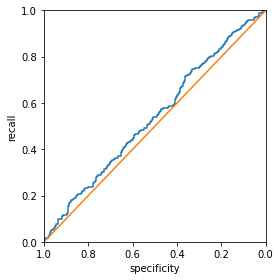

In [78]:


fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], pos_label=0)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()




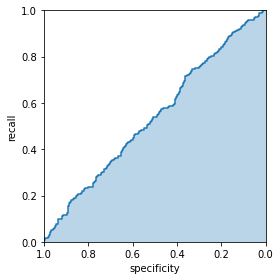

In [79]:



fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label=0)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

